# Generador de Haikus 2.0
En este Notebook se explicará el segundo acercamiento a la creación de un generador de haikus realizado con Deep Learning. 

Para este segundo experimento, se intentará realizar generación de haikus a nivel de palabra, haciendo uso de una red neuronal recurrente con una capa de Embedding y una capa LSTM.

A continuación podemos ver todos los módulos que serán usados en el presente código.

In [3]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, one_hot
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Embedding
import pandas as pd
import csv
import numpy as np
import string as string
import random
import sys

## 1. Configuración del Notebook
En este bloque de código se encuentran los parámetros más importantes a tener en cuenta para la configuración del Notebook.

In [2]:
haiku_path = "all_haiku.csv"
sequence_length = 4
sequence_step = 1

## 2. Preparación del conjunto de entrenamiento
En este caso, uniremos los poemas completamente, sin tener en cuenta su división por versos. Intentaremos realizar un primer acercamiento a la generación de textos usando Embeddings de palabras, puesto que la codificación one-hot requiere de 900 GB de espacio para este conjunto de entrenamiento, cantidad que no es asumible para mi hardware.

En primer lugar leeremos los haikus y los almacenaremos en una lista de cadenas de caracteres. Haremos que estén todos en minúsculas y eliminaremos signos de puntuación y dígitos. También eliminaremos algunos espacios que puedan estar repetidos.

In [4]:
df = pd.read_csv(str(haiku_path), usecols=["0","1","2"])
texts = df[['0', '1', '2']].values
corpus = []
for i in texts:
    aux = str(i[0]) + " " + str(i[1]) + " " + str(i[2])
    aux = "".join(v for v in aux if v not in string.punctuation and v not in string.digits).lower()
    aux = aux.encode("utf8").decode("ascii",'ignore')
    prechar = " "
    char_list = list(aux)
    #Eliminación de espacios repetidos
    for char in range(0,len(char_list)):
        if (prechar is " " or prechar is "\n") and char_list[char] is " ":
            char_list[char-1]=""
        prechar = char_list[char]
    aux = "".join(char_list)
    corpus.append(aux)
corpus[0:10]

['fishing boats colors of the rainbow',
 'ash wednesday trying to remember my dream',
 'snowy morn pouring another cup of black coffee',
 'shortest day flames dance in the oven',
 'haze half the horse hidden behind the house',
 'low sun the lady in red on high heels',
 'advent the passing stranger farts',
 'tarn a bubble in the ice',
 'snowflakes new asphalt in the holes',
 'crystal night gusts of rain outside']

Ahora haremos una división en secuencias de palabras, junto con la palabra que continue la secuencia como objetivo.

Además transformaremos las palabras a números enteros únicos que representen su índice en una lista.

In [9]:
word_list = []
for s in corpus:
    aux = s.split()
    word_list.extend(aux)
unique_words = sorted((set(word_list)))
print("Número de palabras únicas: " + str(len(unique_words)))

sequences, next_words = [], []
corpus = word_list
idx = 0
while idx + sequence_length + 1 < len(corpus):
    words = corpus[idx:idx+sequence_length]
    sequence=""
    for w in words:
        sequence += " " + w
    sequence = sequence.strip()
    nextword = corpus[idx+sequence_length]
    sequences.append(sequence)
    next_words.append(nextword)
    idx += sequence_step

embedded_sentences = [one_hot(sent, len(unique_words)) for sent in sequences]
embedded_next_words = [one_hot(next_word, len(unique_words))[0] for next_word in next_words]

embedded_sentences = np.asarray(embedded_sentences)
embedded_next_words = np.asarray(embedded_next_words)

print("Ejemplo de secuencia tokenizada: ",embedded_sentences[0] )
print("Ejemplo de próxima palabra tokenizada: ", embedded_next_words[0])

Número de palabras únicas: 51866
Ejemplo de secuencia tokenizada:  [20212 29361 45205 19848]
Ejemplo de próxima palabra tokenizada:  30122


In [11]:
proporcion_evaluacion = 0.1
test_x = embedded_sentences[:int(len(embedded_sentences)*proporcion_evaluacion)]
x = embedded_sentences[int(len(embedded_sentences)*proporcion_evaluacion)+1:]
test_y = embedded_next_words[:int(len(embedded_next_words)*proporcion_evaluacion)]
y = embedded_next_words[int(len(embedded_next_words)*proporcion_evaluacion)+1:]

## 3. Creación del modelo
A continuación se creará el modelo que será entrenado. Haremos uso de una capa *LSTM* con 128 celdas y una capa *Dense* con tantas celdas como palabras únicas hayamos encontrado.

Usaremos como función de activación *softmax*, que devolverá una distribución de probabilidad para predecir la siguiente palabra dada una secuencia de entrada.

Haremos uso de la función de pérdida *sparse_categorical_crossentropy*, dado que estamos escogiendo entre varias categorías, las palabras únicas.

In [14]:
model = Sequential()
model.add(Embedding(len(unique_words), 100, input_length=sequence_length, mask_zero = True))
model.add(LSTM(128, input_shape=(sequence_length, 1)))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [15]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4, 100)            5186600   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 51866)             6690714   
_________________________________________________________________
activation_3 (Activation)    (None, 51866)             0         
Total params: 11,994,562
Trainable params: 11,994,562
Non-trainable params: 0
_________________________________________________________________
None


## 4. Entrenamiento del modelo
Ahora entrenaremos el modelo durante 25 épocas con lotes de 256 muestras. Realizaremos validación cruzada con el 20% de los datos en cada época.

In [17]:
history = model.fit(x, y, epochs = 25, batch_size = 256, validation_split = 0.2)
model.save_weights('generador_haikus2.h5')


Train on 1354868 samples, validate on 338717 samples
Epoch 1/25
1354868/1354868 [==============================] - 165s 122us/step - loss: 6.6579 - sparse_categorical_accuracy: 0.0752 - val_loss: 6.1694 - val_sparse_categorical_accuracy: 0.1030: 6.6750 - ETA: 6s - loss: 6.6705 - sparse_categorical_a - ETA: 5s - loss: 6.6690 -  - ETA: 3s - loss: 6.6655 - sparse_categorical_accuracy: - ETA: 3s - loss: 6.6645 - s - ETA: 1s - loss: 6.6608 - sparse_categori - ETA: 0s - loss: 6.6585 - sparse_categorical_accuracy: 0
Epoch 2/25
1354868/1354868 [==============================] - 163s 120us/step - loss: 6.2972 - sparse_categorical_accuracy: 0.1102 - val_loss: 6.0341 - val_sparse_categorical_accuracy: 0.11748 - sp
Epoch 3/25
1354868/1354868 [==============================] - 163s 121us/step - loss: 6.2397 - sparse_categorical_accuracy: 0.1194 - val_loss: 6.0814 - val_sparse_categorical_accuracy: 0.1227s - loss: 6.2314 - sparse_categor - ETA: 9s - loss: 6.2324 - sparse_categorical_accuracy:  - ET

Ahora, representaremos los resultados del entrenamiento en gráficas

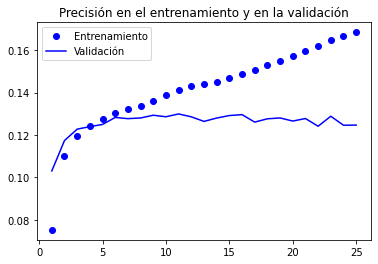

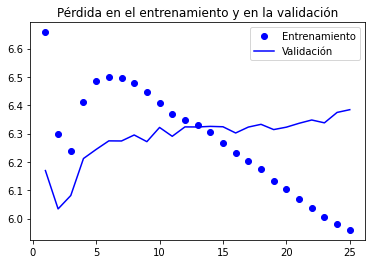

In [18]:
import matplotlib.pyplot as plt

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Entrenamiento')
plt.plot(epochs, val_acc, 'b', label = 'Validación')
plt.title('Precisión en el entrenamiento y en la validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Entrenamiento')
plt.plot(epochs, val_loss, 'b', label = 'Validación')
plt.title('Pérdida en el entrenamiento y en la validación')
plt.legend()

plt.show()

Además de los nefastos resultados obtenidos en cuanto a pérdida y precisión, podemos ver que se ha producido sobreajuste en el modelo, manteniéndose la precisión y la pérdida en el mismo valor para la validación, mientras que en el entrenamiento estos valores mejoraban.
## 5. Evaluación
Ahora, evaluaremos el modelo con las muestras que reservamos en el preprocesamiento de los datos. Estos datos confirmarán si los valores obtenidos en el entrenamiento son correctos, dado que la red no ha trabajado con ellos en ningún momento, son nuevos para ella.

In [19]:
results = model.evaluate(test_x, test_y)
print("Pérdida en la evaluación:", results[0])
print("Precisión en la evaluación:", results[1])

188176/188176 [==============================] - 58s 308us/step
Pérdida en la evaluación: 8.345900101439096
Precisión en la evaluación: 0.08562728762626648


Los resultados muestran que las métricas son incluso peores de lo que se observaba en el entrenamiento. Podemos concluir que este modelo no será útil para generar ningún tipo de haiku.